In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Simple Data Grouping

In [2]:
file_path = r"C:\Users\ADMIN\Downloads\Fintech\HK6\Big Data\Insurance-Claims_Data_Model.xlsx"
excel_file = pd.ExcelFile(file_path)

In [3]:
sheet_names = excel_file.sheet_names

In [4]:
print(f"File có các sheet sau: {sheet_names}")


File có các sheet sau: ['Coverages', 'Products', 'Participants', 'Brokers', 'Policies', 'Regions', 'State Regions', 'Claims Announcements', 'Claims Payments', 'Claims Reserves']


In [5]:
all_dfs = {}
for sheet in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    all_dfs[sheet] = df

In [6]:
all_dfs["Participants"].head()

,ParticipantID,ParticipantCode,LastName,FirstName,BirthDate,Gender,ParticipantType,RegionID,MaritalStatus
0,18,Part-18,Christine,Bowman,1978-03-06,FEMALE,INDIVIDUAL,245,Single
1,110,Part-110,Thomas,Burke,1971-09-04,MALE,INDIVIDUAL,388,Married
2,422,Part-422,Cynthia,Powell,1970-08-21,FEMALE,INDIVIDUAL,263,Single
3,457,Part-457,Gary,Baker,1963-01-01,MALE,INDIVIDUAL,74,Divorced
4,690,Part-690,Ruth,Baker,1952-02-13,FEMALE,INDIVIDUAL,146,Married


In [7]:
for sheet in all_dfs:
    print("----" + sheet + "----")
    print(all_dfs[sheet].isna().sum())

----Coverages----
CoverID                  0
CoverCode                0
RenewalType            109
Room                   115
Participation            0
ProductCategory          0
PremiumMode              0
ProductDistribution      0
dtype: int64
----Products----
ProductID             0
ProductCategory       0
ProductSubCategory    0
Product               0
dtype: int64
----Participants----
ParticipantID        0
ParticipantCode      0
LastName             0
FirstName          183
BirthDate          184
Gender             184
ParticipantType      0
RegionID             0
MaritalStatus      184
dtype: int64
----Brokers----
BrokerID               1
BrokerCode             1
BrokerFullName         1
DistributionNetwork    1
DistributionChannel    0
CommissionScheme       1
dtype: int64
----Policies----
PolicyID                      0
PolicyCode                    0
PolicyInceptionDate           0
CancelationDate            8084
PolicyStartDate               0
PolicyExpirationDate          

In [8]:
all_dfs["Regions"].drop(columns = ['water_area'], inplace = True)

In [9]:
all_dfs["Regions"].drop(columns = ['type'], inplace = True)

In [10]:
all_dfs["Regions"].drop(columns = ['time_zone'], inplace = True)

In [11]:
all_dfs["Regions"].head()

,id,name,county,state_code,state,latitude,longitude,area_code,population,households,median_income,land_area
0,1,Auburn,Lee County,AL,Alabama,32.60986,-85.48078,334,62059,21767,38342,152375113
1,2,Birmingham,Shelby County/Jefferson County,AL,Alabama,33.52744,-86.79905,205,212461,89972,31061,378353942
2,3,Decatur,Limestone County/Morgan County,AL,Alabama,34.57332,-86.99214,256,55437,22294,41496,141006257
3,4,Dothan,Dale County/Houston County/Henry County,AL,Alabama,31.23370,-85.40682,334,68567,25913,42426,232166237
4,5,Hoover,Shelby County/Jefferson County,AL,Alabama,33.37695,-86.80558,205,84848,32789,77146,122016784


In [12]:
# Calculate average latitude and longitude for each state
avg_coordinates = all_dfs["Regions"].groupby("state_code").agg({
    "latitude": "mean",
    "longitude": "mean"
}).reset_index()

coords_dict = dict(zip(avg_coordinates["state_code"], 
                      zip(avg_coordinates["latitude"], avg_coordinates["longitude"])))

# Change the latitude and longitude values in the "Regions" dataframe
all_dfs["Regions"]["latitude"] = all_dfs["Regions"]["state_code"].map(lambda x: coords_dict[x][0])
all_dfs["Regions"]["longitude"] = all_dfs["Regions"]["state_code"].map(lambda x: coords_dict[x][1])

In [13]:
all_dfs["Regions"].drop(columns = ['name', 'county', 'area_code',], inplace = True)

In [14]:
all_dfs["Regions"].head()

,id,state_code,state,latitude,longitude,population,households,median_income,land_area
0,1,AL,Alabama,32.921254,-86.674393,62059,21767,38342,152375113
1,2,AL,Alabama,32.921254,-86.674393,212461,89972,31061,378353942
2,3,AL,Alabama,32.921254,-86.674393,55437,22294,41496,141006257
3,4,AL,Alabama,32.921254,-86.674393,68567,25913,42426,232166237
4,5,AL,Alabama,32.921254,-86.674393,84848,32789,77146,122016784


In [15]:
# Calculate weighted median income for each state
# Formula: Sum(median_income * population) / Sum(population) for each state
all_dfs["Regions"]["weighted_income"] = all_dfs["Regions"]["median_income"] * all_dfs["Regions"]["population"]
state_weighted_data = all_dfs["Regions"].groupby("state").agg({
    "weighted_income": "sum",
    "population": "sum"
}).reset_index()
state_weighted_data["weighted_median_income"] = state_weighted_data["weighted_income"] / state_weighted_data["population"]
weighted_income_dict = dict(zip(state_weighted_data["state"], state_weighted_data["weighted_median_income"]))
all_dfs["Regions"]["median_income"] = all_dfs["Regions"]["state"].map(weighted_income_dict)
all_dfs["Regions"] = all_dfs["Regions"].drop(columns=["weighted_income"])

In [16]:
# Group data by state
state_totals = all_dfs["Regions"].groupby("state").agg({
    "population": "sum",
    "land_area": "sum",
    "households": "sum"
}).reset_index()

pop_dict = dict(zip(state_totals["state"], state_totals["population"]))
area_dict = dict(zip(state_totals["state"], state_totals["land_area"]))
households_dict = dict(zip(state_totals["state"], state_totals["households"]))

all_dfs["Regions"]["population"] = all_dfs["Regions"]["state"].map(pop_dict)
all_dfs["Regions"]["land_area"] = all_dfs["Regions"]["state"].map(area_dict)
all_dfs["Regions"]["households"] = all_dfs["Regions"]["state"].map(households_dict)

In [17]:
all_dfs["Regions"].head()

,id,state_code,state,latitude,longitude,population,households,median_income,land_area
0,1,AL,Alabama,32.921254,-86.674393,1167176,459793,42876.045708,2513138383
1,2,AL,Alabama,32.921254,-86.674393,1167176,459793,42876.045708,2513138383
2,3,AL,Alabama,32.921254,-86.674393,1167176,459793,42876.045708,2513138383
3,4,AL,Alabama,32.921254,-86.674393,1167176,459793,42876.045708,2513138383
4,5,AL,Alabama,32.921254,-86.674393,1167176,459793,42876.045708,2513138383


In [18]:
all_dfs["Participants"].head()

,ParticipantID,ParticipantCode,LastName,FirstName,BirthDate,Gender,ParticipantType,RegionID,MaritalStatus
0,18,Part-18,Christine,Bowman,1978-03-06,FEMALE,INDIVIDUAL,245,Single
1,110,Part-110,Thomas,Burke,1971-09-04,MALE,INDIVIDUAL,388,Married
2,422,Part-422,Cynthia,Powell,1970-08-21,FEMALE,INDIVIDUAL,263,Single
3,457,Part-457,Gary,Baker,1963-01-01,MALE,INDIVIDUAL,74,Divorced
4,690,Part-690,Ruth,Baker,1952-02-13,FEMALE,INDIVIDUAL,146,Married


In [19]:
#Join 2 DataFrames
Participants_and_Regions = pd.merge(
    all_dfs["Participants"],
    all_dfs["Regions"],
    left_on="RegionID",
    right_on="id",
    how="left"
)

Participants_and_Regions = Participants_and_Regions.drop(columns=["id", "RegionID"])

all_dfs["Participants_and_Regions"] = Participants_and_Regions

In [20]:
all_dfs["Participants_and_Regions"]

,ParticipantID,ParticipantCode,LastName,FirstName,BirthDate,Gender,ParticipantType,MaritalStatus,state_code,state,latitude,longitude,population,households,median_income,land_area
0,18,Part-18,Christine,Bowman,1978-03-06,FEMALE,INDIVIDUAL,Single,CT,Connecticut,41.422694,-73.028757,2805709,1048626,57029.219221,2101702918
1,110,Part-110,Thomas,Burke,1971-09-04,MALE,INDIVIDUAL,Married,IL,Illinois,41.672423,-88.156029,10392132,3786841,62011.719304,7256032867
2,422,Part-422,Cynthia,Powell,1970-08-21,FEMALE,INDIVIDUAL,Single,CT,Connecticut,41.422694,-73.028757,2805709,1048626,57029.219221,2101702918
3,457,Part-457,Gary,Baker,1963-01-01,MALE,INDIVIDUAL,Divorced,CA,California,35.413680,-119.305412,27643623,8945768,63915.562373,15049603633
4,690,Part-690,Ruth,Baker,1952-02-13,FEMALE,INDIVIDUAL,Married,CA,California,35.413680,-119.305412,27643623,8945768,63915.562373,15049603633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12300,2560362,Part-2560362,Judith,Dunn,1987-07-27,FEMALE,INDIVIDUAL,Single,GA,Georgia,33.200083,-83.835087,2007390,761127,49945.098903,3781110652
12301,2563276,Part-2563276,WAL-MART Ltd,NaN,NaT,NaN,COMPANY,NaN,MI,Michigan,42.540154,-83.737052,3260843,1263063,48847.867518,2688506487
12302,2574599,Part-2574599,Terry,Cox,1969-08-29,MALE,INDIVIDUAL,Married,MA,Massachusetts,42.282679,-71.230146,2780121,1064704,58789.751599,1541958065
12303,2579714,Part-2579714,Virtus,NaN,NaT,NaN,COMPANY,NaN,IL,Illinois,41.672423,-88.156029,10392132,3786841,62011.719304,7256032867


## I. Customer Profile: Who is insured?

### 1.1 Number of Participants by Gender and Age Group

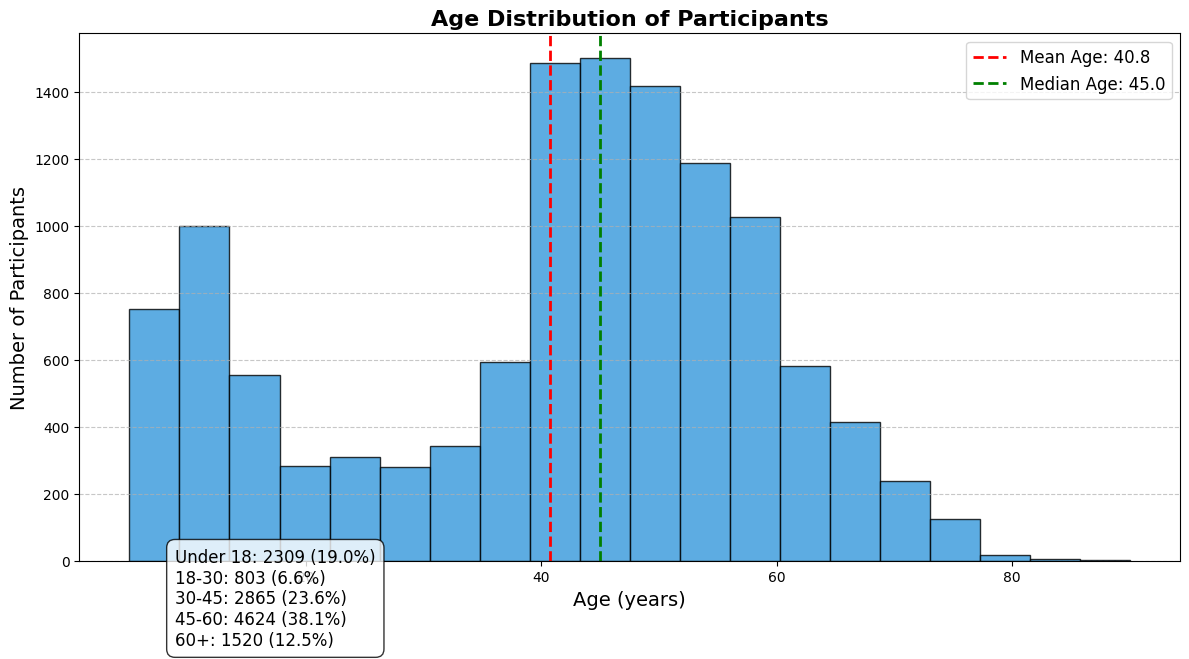

In [21]:
# Create a histogram for age distribution of participants

# Make a copy of the participants dataframe
participants = all_dfs['Participants'].copy()

# Convert BirthDate to datetime
participants['BirthDate'] = pd.to_datetime(participants['BirthDate'], errors='coerce')

# Calculate age based on current date - handle NaN values
current_date = pd.Timestamp.now()
# First calculate as float to handle NaN values
participants['Age'] = (current_date - participants['BirthDate']).dt.days / 365.25
# Drop rows with missing ages before converting to int
participants = participants.dropna(subset=['Age'])
# Now convert to integer
participants['Age'] = participants['Age'].astype(int)

# Filter out any unreasonable ages (e.g., negative or extremely high)
participants = participants[(participants['Age'] >= 0) & (participants['Age'] <= 100)]

# Create the histogram
plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(participants['Age'], bins=20, color='#3498db', alpha=0.8, edgecolor='black')

# Add a vertical line for the mean age
mean_age = participants['Age'].mean()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f'Mean Age: {mean_age:.1f}')

# Add a vertical line for the median age
median_age = participants['Age'].median()
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f'Median Age: {median_age:.1f}')

# Add title and labels
plt.title('Age Distribution of Participants', fontsize=16, fontweight='bold')
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Number of Participants', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=12)

# Calculate and display age group statistics
age_groups = [
    (0, 18, 'Under 18'),
    (18, 30, '18-30'),
    (30, 45, '30-45'),
    (45, 60, '45-60'),
    (60, 100, '60+')
]

age_stats = []
for min_age, max_age, label in age_groups:
    count = participants[(participants['Age'] >= min_age) & (participants['Age'] < max_age)].shape[0]
    percentage = (count / participants.shape[0]) * 100
    age_stats.append(f"{label}: {count} ({percentage:.1f}%)")

# Add text box with age group statistics
plt.figtext(0.15, 0.02, '\n'.join(age_stats), fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for the text at the bottom
plt.show()


### **1.1.1 Overview of the Age Distribution Chart**

The chart clearly shows the age distribution of customers participating in each age group. The data is divided into the following groups:

| Age Group     | Quantity | Percentage (%) |
|---------------|----------|----------------|
| Under 18      | 2,309    | 19.0%          |
| 18–30         | 803      | 6.6%           |
| 30–45         | 2,868    | 23.7%          |
| 45–60         | 4,621    | 38.1%          |
| Over 60       | 1,520    | 12.5%          |

### **1.1.2 Detailed Insights from the Chart**

#### 1. Main customer group: Middle-aged (45–60)
- This group makes up the largest share (38.1%), suggesting that this age group has a high demand for insurance, possibly due to:
  - Stable income.
  - Growing concern about health and retirement planning.
  - Focus on protecting assets and family.

#### 2. The 30–45 age group also represents a large share (23.7%)
- This group is in the process of building careers and starting families.
- They have the financial capability to participate in long-term insurance (life insurance, family health insurance, etc.).

#### 3. The under-18 age group still represents 19.0%
- This suggests that many insurance policies are purchased by parents for their children, such as education insurance and children's health insurance.

#### 4. The 18–30 age group has a low participation rate (6.6%)
- This group participates in insurance the least.
- Possible reasons:
  - Low income.
  - Lack of awareness or financial prioritization for insurance.

#### 5. Mean & Median Age
- Mean (Average): 40.8 years – indicating that the company serves mostly middle-aged customers.
- Median: 45.0 years – suggesting a slight left skew in the distribution, with more customers aged over 45.

### **1.1.3 Business Strategy from This Data**

#### Focus on the 30–60 age group
- This is the main group currently → continue optimizing health insurance, life insurance, and retirement savings packages.

#### Expand the market to the 18–30 age group
- Design affordable and flexible insurance packages, suitable for:
  - Young professionals.
  - Small savings insurance, online insurance.
- Strengthen financial education through social media and influencers.

#### Target parents with children under 18
- Promote educational insurance and children's health insurance products.

### **1.1.4 Summary Conclusion**
The age distribution chart shows that the insurance company is effectively targeting the middle-aged group, but there is significant potential in the youth and children markets through specific marketing strategies and product development. Segmenting and developing age-targeted personalized products will help increase customer growth effectively.

## 1.2 Gender and Marial Status Analysis

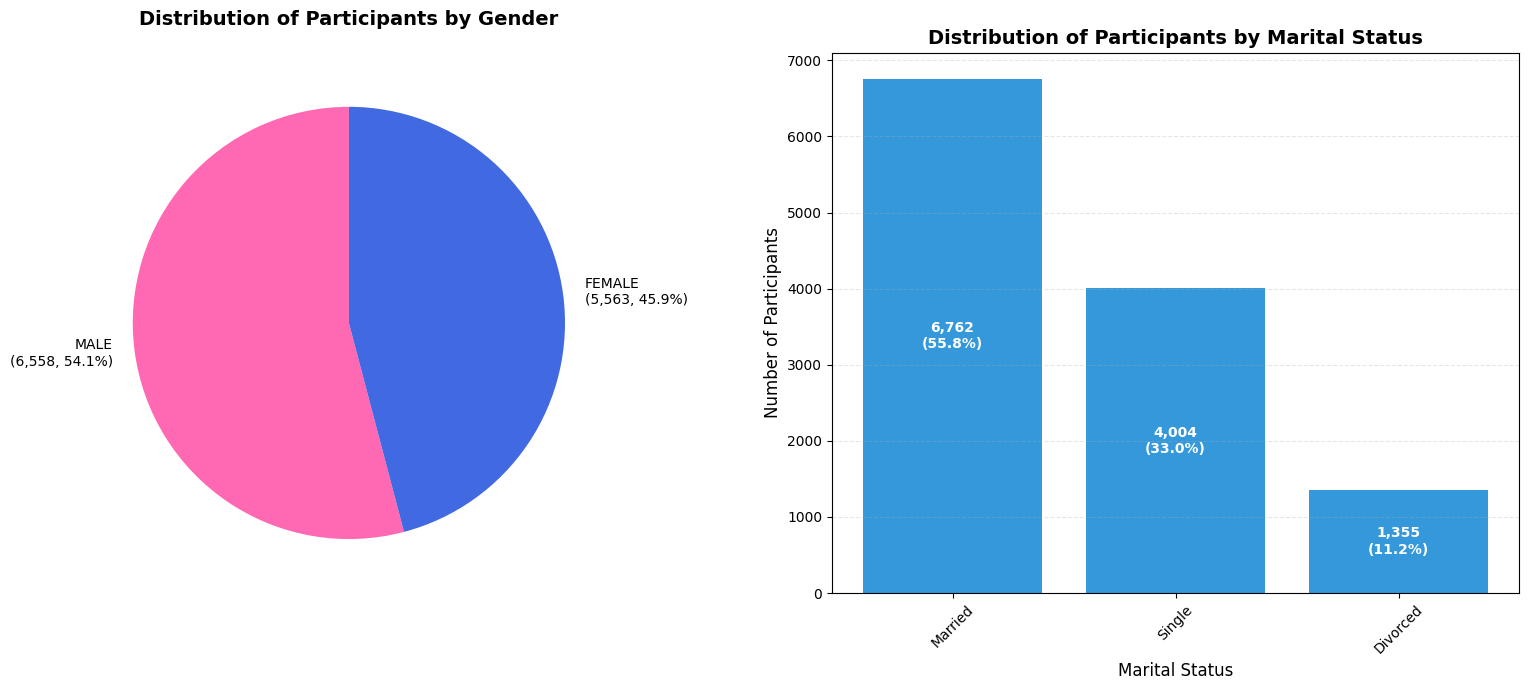

In [22]:
# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 1. Gender Distribution (Pie Chart)
gender_counts = all_dfs['Participants']['Gender'].value_counts()
gender_percentages = (gender_counts / gender_counts.sum() * 100).round(1)

colors_gender = ['#FF69B4', '#4169E1']  # Pink and Blue
ax1.pie(gender_counts, labels=[f'{label}\n({count:,}, {pct}%)' 
        for label, count, pct in zip(gender_counts.index, gender_counts, gender_percentages)],
        colors=colors_gender, autopct='', startangle=90)
ax1.set_title('Distribution of Participants by Gender', fontsize=14, fontweight='bold', pad=20)

# 2. Marital Status Distribution (Bar Chart)
marital_counts = all_dfs['Participants']['MaritalStatus'].value_counts()
marital_percentages = (marital_counts / marital_counts.sum() * 100).round(1)

bars = ax2.bar(marital_counts.index, marital_counts, color='#3498db')

# Add data labels on the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{marital_counts.iloc[i]:,}\n({marital_percentages.iloc[i]}%)',
             ha='center', va='center', color='white', fontweight='bold')

ax2.set_title('Distribution of Participants by Marital Status', fontsize=14, fontweight='bold')
ax2.set_xlabel('Marital Status', fontsize=12)
ax2.set_ylabel('Number of Participants', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# Rotate x-axis labels if needed
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### **1.2.1 Gender Analysis**  
**Total Participants:** 11,921

| Gender | Count | Percentage (%) |
|--------|-------|----------------|
| Male   | 6,658 | 54.1%          |
| Female | 5,263 | 45.9%          |

#### Observations
- The gender distribution is relatively balanced, though males slightly outnumber females (~8.2% difference).
- This may reflect:
  - Men often being the financial decision-makers and primary policyholders.
  - Or a higher male ratio in the target customer segment or industry.

#### Strategy
- Increase engagement with female customers via:
  - Women-focused health products, maternity insurance, family insurance.
  - Marketing through platforms and influencers that appeal to female audiences.

---

### **1.2.2 Marital Status Analysis**  
**Total with recorded marital status:** 12,121

| Marital Status | Count | Percentage (%) |
|----------------|-------|----------------|
| Married        | 6,762 | 55.8%          |
| Single         | 4,004 | 33.0%          |
| Divorced       | 1,355 | 11.2%          |

#### Observations
- Married individuals represent the majority (55.8%), indicating:
  - Higher financial responsibility.
  - A tendency to prioritize insurance for family protection.
- Single individuals are also a significant segment (33%) – showing that many financially independent young people are aware of insurance.
- Divorced individuals (11.2%) – may need more personalized financial protection post-divorce.

#### Strategy
- **For married individuals**: Develop family plans, education savings insurance, spouse-focused products.
- **For singles**: Emphasize long-term protection, future planning, and personal health coverage.
- **For divorced individuals**: Offer flexible, personalized products to support post-life-change financial stability.

---

### **1.2.3 Summary Insights**

| Key Group Characteristic          | Recommended Strategy                                         |
|----------------------------------|--------------------------------------------------------------|
| Males slightly outnumber females | Maintain neutral marketing, expand female-focused offerings  |
| Majority are married             | Focus on family-oriented products, child education savings   |
| Singles are a large segment      | Offer low-cost, personalized, flexible products              |
| Divorced is a small but distinct group | Provide post-divorce financial support and tailored products |


## 1.3 Number of Policies by Gender

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_28116\32396735.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  policy_counts = participants.groupby(['Gender', 'AgeGroup']).size().unstack()


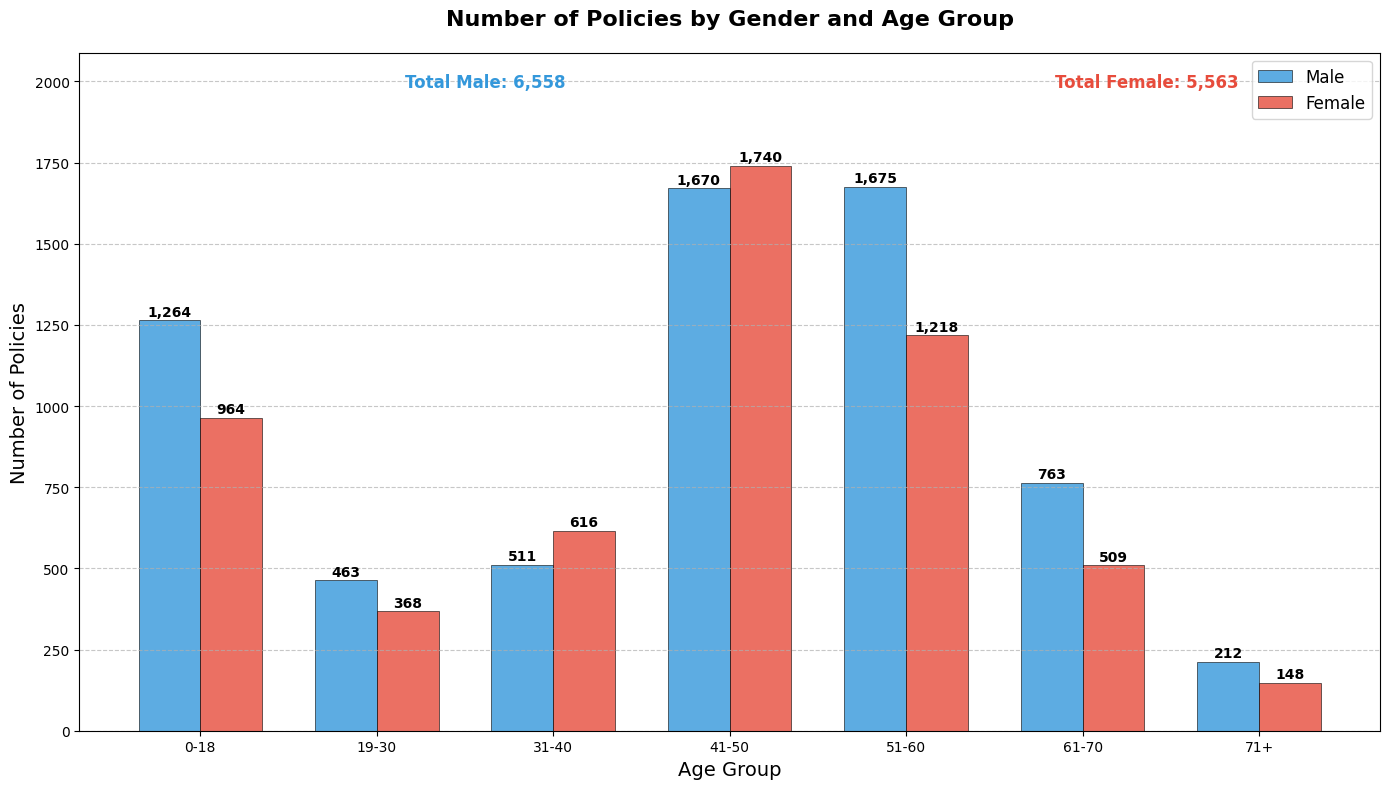

In [23]:
# Extract the necessary data
participants = all_dfs['Participants'].copy()

# Convert BirthDate to datetime
participants['BirthDate'] = pd.to_datetime(participants['BirthDate'])

# Calculate age
current_year = pd.Timestamp.now().year
participants['Age'] = current_year - participants['BirthDate'].dt.year

# Create age groups
age_bins = [0, 18, 30, 40, 50, 60, 70, 100]
age_labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71+']
participants['AgeGroup'] = pd.cut(participants['Age'], bins=age_bins, labels=age_labels, right=False)

# Count policies by gender and age group
policy_counts = participants.groupby(['Gender', 'AgeGroup']).size().unstack()

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Set width of bars
bar_width = 0.35
index = np.arange(len(age_labels))

# Plot bars for each gender
male_bars = ax.bar(index - bar_width/2, policy_counts.loc['MALE'], bar_width, 
                  label='Male', color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.5)
female_bars = ax.bar(index + bar_width/2, policy_counts.loc['FEMALE'], bar_width, 
                    label='Female', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.5)

# Add data labels on top of each bar
for bars in [male_bars, female_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:,}', ha='center', va='bottom', fontweight='bold')

# Add title and labels
ax.set_title('Number of Policies by Gender and Age Group', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Age Group', fontsize=14)
ax.set_ylabel('Number of Policies', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(age_labels)
ax.legend(fontsize=12)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add totals for each gender
male_total = policy_counts.loc['MALE'].sum()
female_total = policy_counts.loc['FEMALE'].sum()
ax.text(0.25, 0.95, f'Total Male: {male_total:,}', transform=ax.transAxes, 
        fontsize=12, fontweight='bold', color='#3498db')
ax.text(0.75, 0.95, f'Total Female: {female_total:,}', transform=ax.transAxes, 
        fontsize=12, fontweight='bold', color='#e74c3c')

# Set y-axis limit to provide more space at the top
y_max = max(policy_counts.loc['MALE'].max(), policy_counts.loc['FEMALE'].max()) * 1.2
ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

### **1.3.1 KEY INSIGHTS**

#### AGE GROUP 41–50:
- Represents **28.1% of total insurance contracts**.
- Both **male and female customers peak** in this group → This is the **golden age group for insurance**.

#### FEMALES SURPASS MALES IN 31–40 AGE GROUP:
- Women start to **dominate from age 31**, indicating:
  - Financial independence.
  - Increased focus on self-protection and family security.

#### SURPRISINGLY HIGH PARTICIPATION IN 0–18 AGE GROUP:
- Policies are registered under children’s names but **purchased by parents**.
- Opportunity to develop:
  - **Education insurance**.
  - **Children’s health insurance**.

---

### **1.3.2 STRATEGIC RECOMMENDATIONS**

| **Age Group** | **Product Direction** |
|---------------|-----------------------|
| **0–18**      | Education insurance, children’s health insurance |
| **19–30**     | Starter insurance plans, low-cost flexible packages, investment-linked products |
| **31–40**     | Focus on women – maternity insurance, women’s health care plans |
| **41–50**     | Premium insurance packages, retirement savings, long-term investments |
| **51–60**     | Expand reach through banks and corporate channels |
| **61+**       | Health insurance, long-term care support packages |


## 1.4 Participant Types Distribution

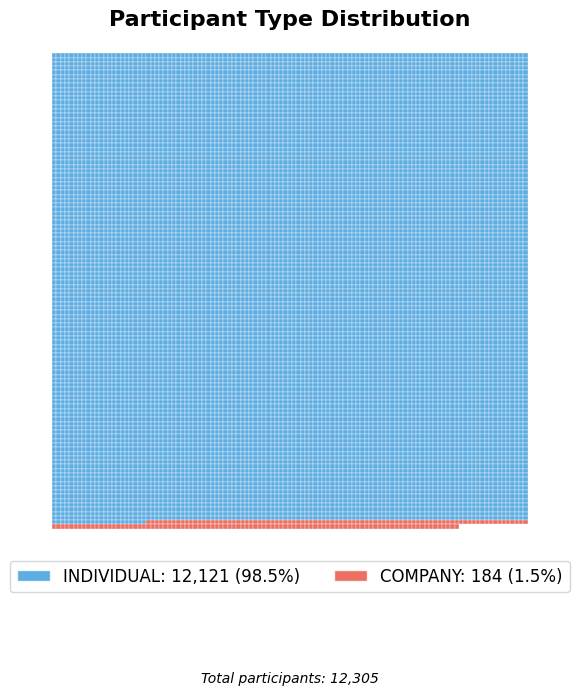

In [24]:
# Create a waffle chart for ParticipantType distribution

# Extract the necessary data
participants = all_dfs['Participants'].copy()

# Count by ParticipantType
type_counts = participants['ParticipantType'].value_counts().reset_index()
type_counts.columns = ['ParticipantType', 'Count']

# Calculate percentages
total = type_counts['Count'].sum()
type_counts['Percentage'] = (type_counts['Count'] / total * 100).round(1)

# Define colors for each participant type
color_map = {
    'INDIVIDUAL': '#3498db',  # Blue for individuals
    'COMPANY': '#e74c3c',     # Red for companies
}

# Add any other participant types with different colors
unique_types = type_counts['ParticipantType'].unique()
for type_name in unique_types:
    if type_name not in color_map:
        color_map[type_name] = '#2ecc71'  # Default green for other types

# Create the figure
fig, ax = plt.subplots(figsize=(6, 8))

# Calculate grid dimensions
n_cells = total
grid_size = int(np.ceil(np.sqrt(n_cells)))


# Create a grid of cells
cells = np.zeros((grid_size, grid_size))

# Assign participant types to cells
current_pos = 0
type_positions = {}

for _, row in type_counts.iterrows():
    type_name = row['ParticipantType']
    count = row['Count']
    type_positions[type_name] = []
    
    for _ in range(count):
        if current_pos < grid_size * grid_size:
            row_idx = current_pos // grid_size
            col_idx = current_pos % grid_size
            cells[row_idx, col_idx] = 1
            type_positions[type_name].append((row_idx, col_idx))
            current_pos += 1

# Plot the waffle chart
for type_name, positions in type_positions.items():
    for pos in positions:
        rect = plt.Rectangle(
            (pos[1], grid_size - pos[0] - 1), 
            1, 1, 
            facecolor=color_map[type_name],
            edgecolor='white',
            alpha=0.8,
            linewidth=0.3
        )
        ax.add_patch(rect)

# Set the limits and aspect ratio
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')

# Remove axes
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a title
plt.title('Participant Type Distribution', 
          fontsize=16, fontweight='bold', pad=20)

# Create a legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color_map[type_name], edgecolor='white', alpha=0.8)
    for type_name in type_counts['ParticipantType']
]

ax.legend(
    legend_elements,
    [f"{row['ParticipantType']}: {row['Count']:,} ({row['Percentage']}%)" 
     for _, row in type_counts.iterrows()],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=len(type_counts),
    frameon=True,
    fontsize=12
)

# Add a note about the visualization
plt.figtext(
    0.5, 0.01, 
    f"Total participants: {total:,}",
    ha='center',
    fontsize=10,
    fontstyle='italic'
)

plt.tight_layout()
plt.show()

### **1.4.1 Participant Type Analysis**

#### Data Summary
- **Individual Participants:** 12,121 (**98.5%**)
- **Corporate Participants:** 184 (**1.5%**)

> This clear imbalance emphasizes a strong focus on individuals in the company’s current strategy.

---

#### Interpretation and Business Insights

| Participant Type | Count  | Percentage | Interpretation |
|------------------|--------|------------|----------------|
| **Individual**   | 12,121 | 98.5%      | The vast majority of insurance contracts are held by individuals. This indicates the business is highly focused on personal insurance products and the retail market. |
| **Corporate**    | 184    | 1.5%       | Corporate clients are significantly underrepresented. This suggests a major untapped opportunity in the B2B and group insurance sectors. |

---

#### Root Causes for Low Corporate Participation
- Lack of well-designed group insurance packages tailored to business needs.
- Limited marketing strategies targeting small and medium-sized enterprises (SMEs).
- Insufficient incentives or HR-aligned policies to support employers in offering insurance to staff.

---

### **1.4.2 Strategic Recommendations**

| Objective                 | Suggested Action                                                                 |
|---------------------------|----------------------------------------------------------------------------------|
| **Grow the corporate segment** | Develop exclusive insurance packages for employee groups with flexible terms and attractive premiums |
| **Improve market outreach**    | Host seminars and digital campaigns aimed at SME decision-makers             |
| **Form strategic alliances**   | Collaborate with HR solution providers to integrate insurance into HR platforms |
| **Broaden distribution**       | Utilize banks, business chambers, and corporate insurance agents for B2B access |

---

### **1.4.3 Conclusion**
It is clear that individuals form the dominant share of the company’s current policyholders. However, this also reveals a substantial opportunity for expansion in the underdeveloped corporate insurance market. With targeted initiatives and product innovation, this segment can be strategically grown to balance and diversify the overall customer portfolio.


## 1.5 Customer Distribution by State

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_28116\2670851585.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((row['longitude'] + lon_adjust, row['latitude'] + lat_adjust),


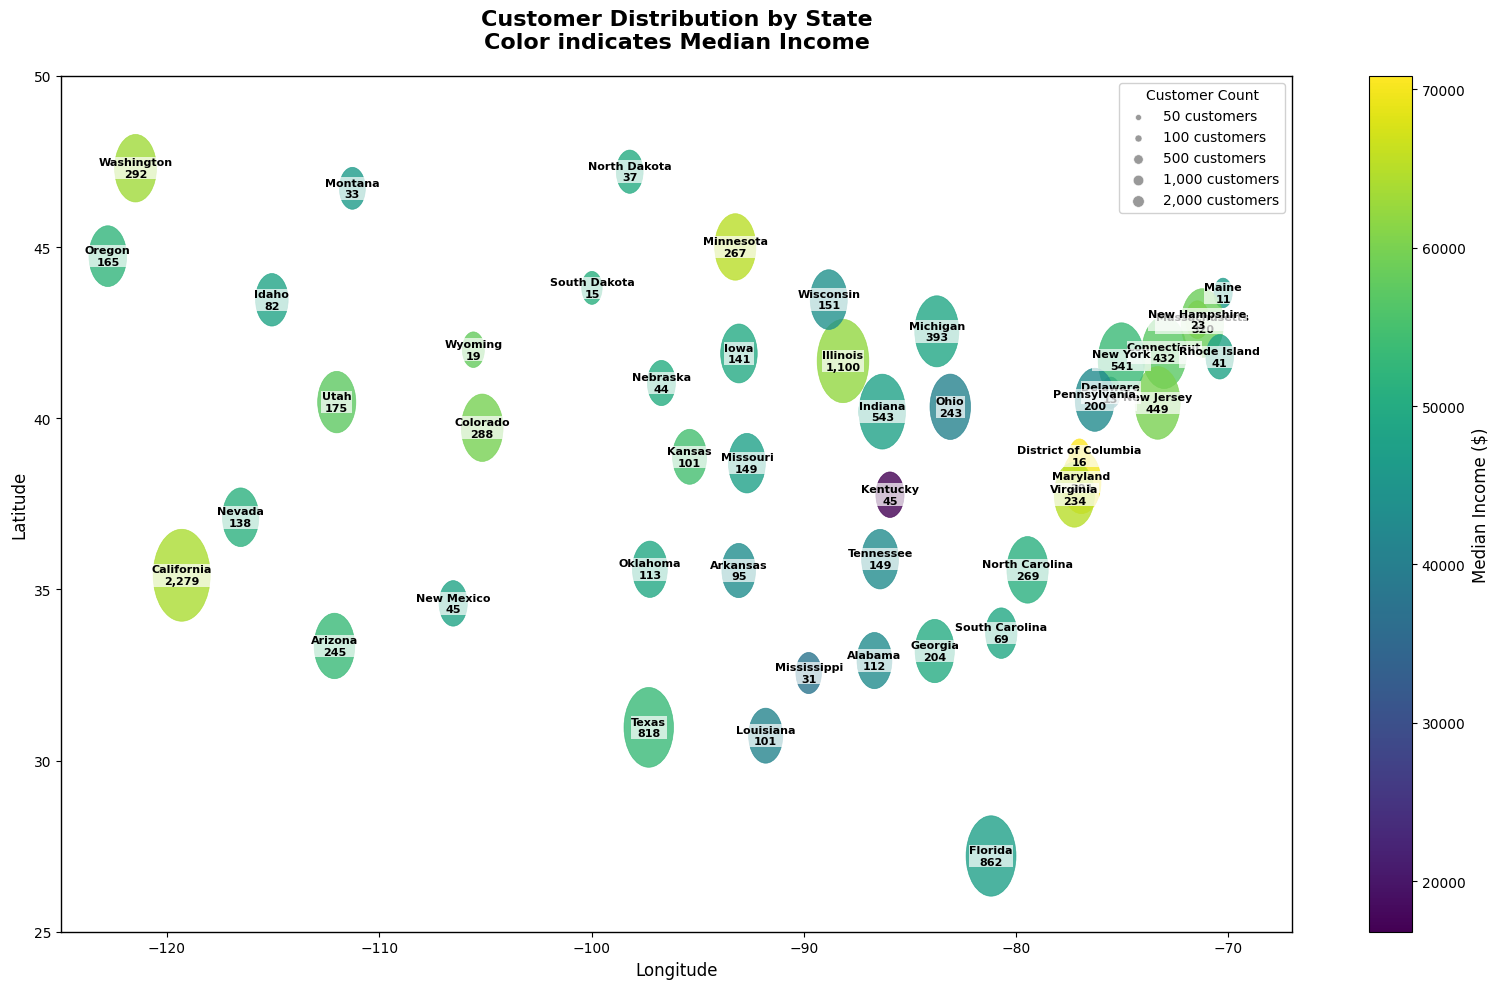

In [25]:
# Filter out Hawaii and adjust the visualization
state_data = all_dfs["Participants_and_Regions"].groupby(['state', 'latitude', 'longitude', 'median_income']).size().reset_index(name='customer_count')
state_data = state_data[state_data['state'] != 'Hawaii']

# Create the US map plot with proper axes setup and room for colorbar
fig, ax = plt.subplots(figsize=(18, 10))

# Create color scale based on median income
norm = plt.Normalize(state_data['median_income'].min(), state_data['median_income'].max())
cmap = plt.cm.viridis

# Create bubbles for each state
for _, row in state_data.iterrows():
    # Adjusted bubble size calculation
    size = np.log10(row['customer_count'] + 1) * 0.4
    
    # Adjust positions for overlapping states
    lat_adjust = 0
    lon_adjust = 0
    
    # Manual adjustments for specific states to prevent overlap
    if row['state'] == 'Delaware':
        lat_adjust = 1
    elif row['state'] == 'Maryland':
        lat_adjust = -1
    elif row['state'] == 'New Jersey':
        lon_adjust = 1
    elif row['state'] == 'Connecticut':
        lat_adjust = 0.5
    elif row['state'] == 'Rhode Island':
        lon_adjust = 1
    elif row['state'] == 'Massachusetts':
        lat_adjust = 0.5
    
    # Create and add the bubble with adjusted position
    circle = plt.Circle((row['longitude'] + lon_adjust, row['latitude'] + lat_adjust), 
                       size, 
                       alpha=0.8,
                       color=cmap(norm(row['median_income'])),
                       edgecolor='white',
                       linewidth=0.5)
    ax.add_patch(circle)
    
    # Enhanced label formatting with adjusted position
    ax.annotate(f"{row['state']}\n{row['customer_count']:,}", 
                (row['longitude'] + lon_adjust, row['latitude'] + lat_adjust),
                xytext=(0, 0), 
                textcoords='offset points',
                fontsize=8,
                ha='center',
                va='center',
                color='black',
                weight='bold',
                bbox=dict(facecolor='white', 
                         alpha=0.7, 
                         edgecolor='none',
                         pad=0.3))

# Adjusted map boundaries to fit content better and leave room for colorbar
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)

# Draw rectangular border
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# Enhanced title and labels
ax.set_title('Customer Distribution by State\nColor indicates Median Income', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Updated legend with clearer size representation
actual_counts = [50, 100, 500, 1000, 2000]
legend_elements = [plt.scatter([], [], s=(np.log10(size + 1) * 0.4)**2 * 40, 
                             alpha=0.8, 
                             color='gray',
                             edgecolor='white',
                             linewidth=0.5,
                             label=f'{size:,} customers') 
                  for size in actual_counts]

ax.legend(handles=legend_elements, 
         title='Customer Count',
         loc='upper right',
         bbox_to_anchor=(1.0, 1.0),
         framealpha=0.9)

# Enhanced colorbar with more space
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.05)  # Increased padding
cbar.set_label('Median Income ($)', fontsize=12)

# Adjust layout to make room for colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave 10% of space on the right

plt.show()

### **1.5.1 Geographic Distribution Chart**
- **Ellipse Size**: Number of customers per state  
- **Color Gradient**: Median income (purple = low, yellow = high)

---

### **1.5.2 Key Summary**

| **State**             | **# of Customers** | **Median Income** | **Insights**                                                |
|-----------------------|--------------------|-------------------|-------------------------------------------------------------|
| **California**        | 2,179              | ~$65,000+         | Highest number of customers; also among the highest income  |
| **Texas**             | 818                | ~$55,000          | Large customer base; average income                         |
| **Florida**           | 822                | ~$50,000          | Many customers; moderate income                             |
| **Illinois**          | 1,100              | ~$55,000          | High customer count with average income                     |
| **New York**          | 682                | ~$60,000+         | Many customers with high income                             |
| **District of Columbia** | 56            | $70,000+           | Few customers but highest financial potential               |

---

### **1.5.3 Color Analysis – Median Income**

- **Yellow Areas**: Higher income → Potential for premium products  
  - *District of Columbia, Maryland, New Jersey, California, Minnesota*

- **Purple/Dark Blue Areas**: Lower income → Focus on affordable or installment-based packages  
  - *Mississippi, Alabama, Kentucky*

---

### **1.5.4 Regional Breakdown**

#### 1. **West Region**
- **Top State**: California (dominates)
- **Secondary Potential**: Oregon, Arizona
- **Emerging**: Idaho, Utah, Nevada

#### 2. **Northeast**
- **Strong States**: New York, New Jersey, Pennsylvania
- Dense, affluent urban markets → ideal for high-touch marketing

#### 3. **South**
- **Large Volume**: Texas, Florida, Georgia
- **Note**: High customer count, but moderate incomes → Price sensitivity

#### 4. **Midwest**
- **Stable Markets**: Illinois, Ohio, Michigan
- Balanced income and customer size → steady performance

---

### **1.5.5 Suggested Marketing Strategy by Region**

| **Region**                 | **Marketing Strategy**                                         |
|---------------------------|---------------------------------------------------------------|
| California, New York, DC  | Offer premium plans with added benefits                       |
| Texas, Florida            | Focus on volume, promote essential/basic packages             |
| Kentucky, Alabama, MS     | Installment-friendly plans, financial support features        |

---

### **1.5.6 Strategic Takeaways**

- Prioritize **California, Texas, Florida, Illinois, New York**  
- **Customize strategy** per state based on median income and customer volume  
- Identify **high-income, low-penetration states** (e.g., DC, Maryland) for pilot expansions

## 1.6 Distribution of Policies by Customer-Insured Relationship

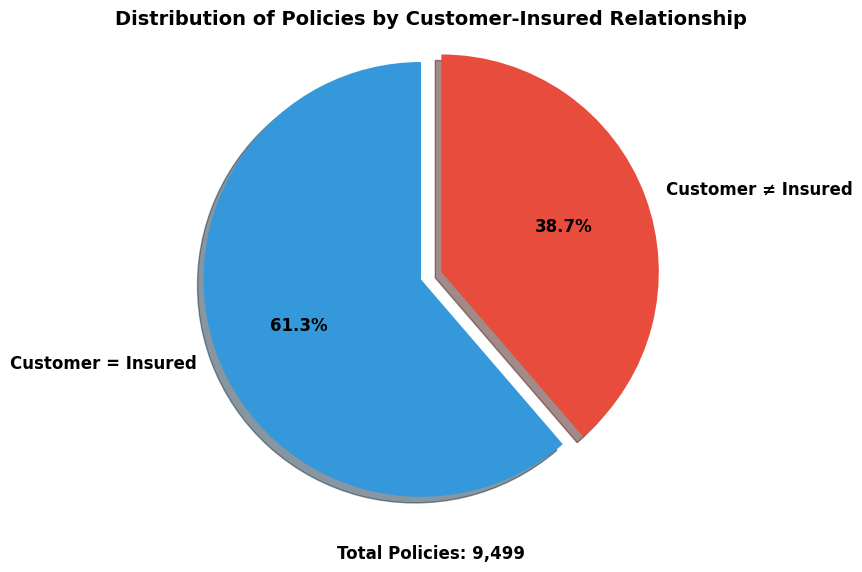

In [27]:
# Extract the Policies data
policies = all_dfs['Policies'].copy()

# Identify policies where CustomerID equals InsuredID (same person)
policies['IsSameCustomerInsured'] = policies['CustomerID'] == policies['InsuredID']

# Count the number of policies in each category
same_id_count = policies[policies['IsSameCustomerInsured'] == True].shape[0]
different_id_count = policies[policies['IsSameCustomerInsured'] == False].shape[0]

# Create data for the pie chart
labels = ['Customer = Insured', 'Customer ≠ Insured']
sizes = [same_id_count, different_id_count]

# Create a figure for the pie chart
plt.figure(figsize=(8, 6))

# Create pie chart
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)  # explode the 1st slice (Customer = Insured)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Policies by Customer-Insured Relationship', fontsize=14, fontweight='bold')

# Add total count
plt.figtext(0.5, 0.01, f'Total Policies: {len(policies):,}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()